In [286]:
import os
import json
import matplotlib.pyplot as plt

In [287]:
# Collect organizations and their co-occurences

orgs = []
texts = []
years = []
occurences = []

dir = 'json/'
files = os.listdir(dir)

for index, filename in enumerate(files):
    
    f = open(dir + filename)
    r = f.read()
    parsed = json.loads(r)
    
    # Set tags and remove excessive values

    tags = parsed[0]['story_tags']

    if len(tags) > 1000:
        continue

    # Set time

    try:
        year = int(parsed[0]['publish_date'].split(' ')[0].split('-')[0])
    except:
        continue

    # Collect organizations' names
    
    _names = []

    for tag in tags:
        if (tag['tag_set'] == 'cliff_organizations'):
            label = tag['tag']
            if label.startswith('U.S. '): label = label.replace('U.S. ', '')
            if label.startswith('US '): label = label.replace('US ', '')
            # if 'Information Administration' in label: print(label)
            if label == 'EU': label = 'European Union'
            if label == 'E.U.': label = 'European Union'
            if label == 'IEA': label = 'International Energy Agency'
            if label == 'Exxon': label = 'Exxon Mobil'
            if label == 'Exxon Mobil': label = 'ExonnMobil'
            if label == 'ExxonMobil': label = 'ExonnMobil'
            if label == 'U.S. Energy Information Administration': label = 'Energy Information Administration'
            if label == 'Massachusetts Institute of Technology': label = 'MIT'
            if label == 'U.N.': label = 'United Nations'
            if label == 'UN': label = 'United Nations'
            if label == 'EDF': label = 'Environmental Defense Fund'
            if label == 'Interior': label = 'Interior Department'
            if label == 'EIA': label = 'Energy Information Administration'
            if label == 'AP': label = 'Associated Press'
            if label == 'NOAA': label = 'National Oceanic and Atmospheric Administration'
            if label == 'U.S. Forest Service': label = 'Forest Service'
            if label == 'U.S. Department of Energy': label = 'Energy Department'
            if label == 'Department of Energy': label = 'Energy Department'
            if label == 'Energy': label = 'Energy Department'
            if label == 'GE': label = 'General Electric'
            if label == 'Stanford': label = 'Stanford University'
            if label == 'NRDC': label = 'Natural Resources Defense Council'
            if label == 'EPA': label = 'Environmental Protection Agency'
            if label == 'Harvard': label = 'Harvard University'
            if label == 'House': label = 'White House'
            if label == 'University of California, Berkeley': label = 'University of California'
            _names.append(label)

    # Collect by name

    # x -> years
    # y -> occurencies

    for n in _names:
        if n in orgs:
            
            index = orgs.index(n)
            texts[index] = texts[index] + _names
            occurences[index] += 1
            
            if year in years[index]:
                years[index][year] += 1
            else:
                years[index][year] = 1
                
        else:
            orgs.append(n)
            texts.append(_names)
            occurences.append(1)
            years.append({year: 1})


# Clean less citates organizations

for index, occurrence in reversed(list(enumerate(occurences))):

    min = 10

    if occurrence < min:
        orgs.pop(index)
        texts.pop(index)
        years.pop(index)
        occurences.pop(index)
    # else:
        # print()
        # print(index, occurrence, orgs[index])
        # print()

# order years by key in an array of tuples

for index, y in enumerate(years):
    sortedDict = dict( sorted(y.items(), key=lambda x: x[0]) )
    _temp = {}
    for k,v in sortedDict.items():
        _temp[k] = v
    years[index] = _temp

print(len(orgs), len(texts), len(years), len(occurences))

# print(texts[0])
# print(years[0][:, 0])



365 365 365 365


In [297]:
# Linear regression

import numpy as np
from sklearn.linear_model import LinearRegression

slopes = []
colors = []

for year in years:

    y = list(year.values())
    x = list(year.keys())

    print()
    print(x, y)

    x = np.array(x).reshape((-1, 1))
    
    model = LinearRegression().fit(x, y)
    slope = model.coef_
    score = model.score(x, y)
    print('slope', slope)
    print('score', score)

    slopes.append(slope)

    if slope > .5:
        colors.append('red')
    else:
        colors.append('blue')

    # if slope > .5:
    #     colors.append('red')
    # else:
    #     if slope > -.5:
    #         colors.append('orange')
    #     else:
    #         colors.append('blue')



# x = np.array([5, 15, 25, 35, 45, 55]).reshape((-1, 1))
# y = np.array([5, 20, 14, 32, 22, 38])

 2014, 2015, 2016, 2017] [1, 3, 3, 3, 3, 7, 1]
slope [0.28571429]
score 0.09523809523810878

[2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019] [1, 9, 9, 7, 12, 24, 24, 14, 4]
slope [1.23333333]
score 0.1761149228130512

[2011, 2013, 2015, 2017, 2018, 2019] [2, 3, 3, 2, 3, 1]
slope [-0.08421053]
score 0.10105263157894995

[2015, 2017, 2018, 2019] [1, 3, 5, 1]
slope [0.28571429]
score 0.0649350649350886

[2013, 2014, 2015, 2016, 2017, 2018, 2019] [1, 1, 4, 3, 1, 4, 1]
slope [0.10714286]
score 0.025000000000004574

[2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019] [3, 2, 5, 2, 2, 6, 4, 3, 1]
slope [-0.05]
score 0.007180851063827043

[2011, 2012, 2013, 2015, 2016, 2017, 2018, 2019] [2, 5, 5, 4, 8, 5, 8, 1]
slope [0.14012739]
score 0.0265758840325091

[2011, 2012, 2013, 2014, 2015, 2017] [3, 2, 2, 4, 1, 1]
slope [-0.28571429]
score 0.27874564459926043

[2011, 2012, 2013, 2015, 2016, 2017] [1, 2, 1, 1, 3, 6]
slope [0.60714286]
score 0.5338669950738482

[2012, 2013, 2014, 2015, 2016

In [298]:
# Term Frequency Matrix

import textacy

doc_term_matrix, dictionary = textacy.representations.build_doc_term_matrix(texts, tf_type="linear", idf_type="smooth")

 * creating mesh with size 61 61
 * filling mesh


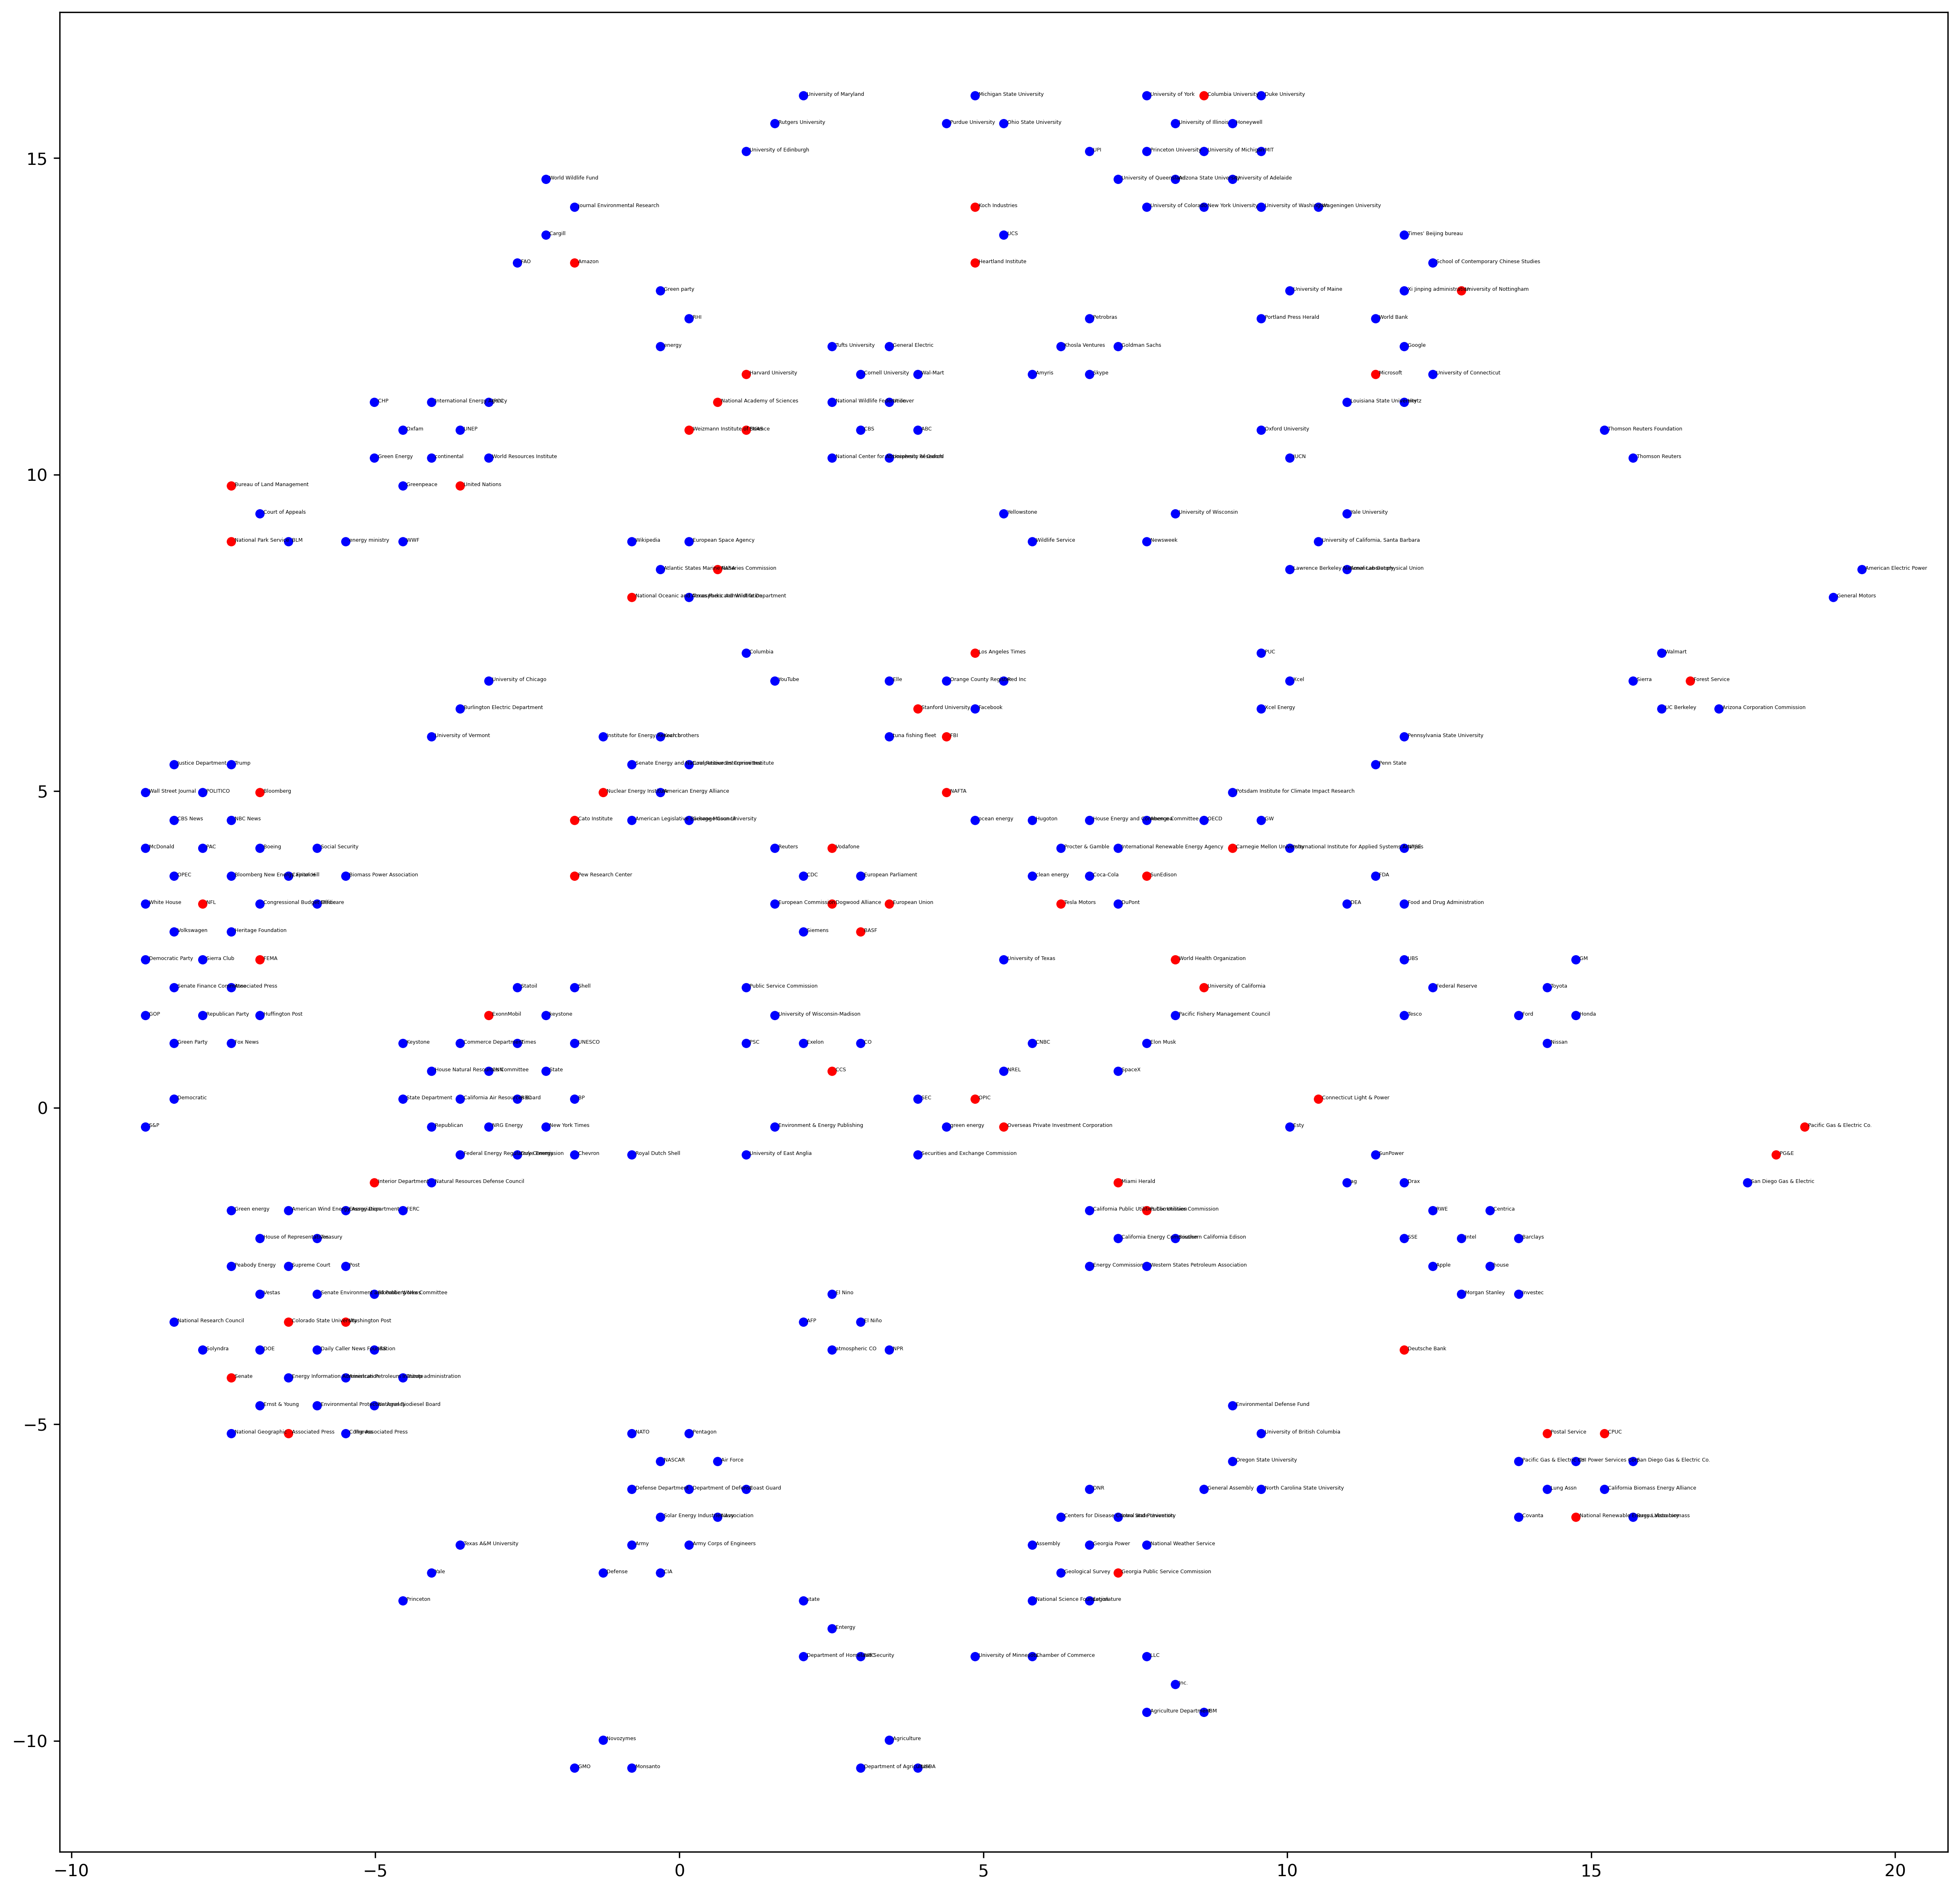

In [299]:
# UMAP

import umap
import matplotlib.pyplot as plt
from pointgrid import align_points_to_grid


reducer = umap.UMAP(n_components=2, n_neighbors=2, min_dist=0.01, metric='cosine')
# reducer = umap.UMAP(random_state=2, n_components=2, n_neighbors=2, min_dist=0.01, metric='hellinger')

embedding = reducer.fit_transform(doc_term_matrix)
embedding = align_points_to_grid(embedding)

x = embedding[:, 0]; y = embedding[:, 1]

plt.figure(figsize=(20,20), dpi=300)
plt.scatter(x, y, s=20, c=colors)

for i, txt in enumerate(orgs):
    text = plt.annotate(' ' + orgs[i], (x[i] + .03, y[i]))
    text.set_fontsize(3)

plt.savefig('/Users/dario/Desktop/download.png')